## 单流体嵌入网络的PFGs聚合物

In [74]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler

In [75]:
current_directory = os.getcwd()
print(current_directory)

/home/redfu/work/Constitutive_Equation/MFNN/singlefluid


In [76]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 40
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取 Excel 文件中的所有 sheet
url_hf = 'Data/DifferComponent_data.xlsm'
df_HF = pd.read_excel(url_hf, sheet_name=None)
# 初始化训练集和验证集
train_set = pd.DataFrame()  # 用于存储训练集
valid_set = pd.DataFrame()  # 用于存储验证集

# 遍历所有 sheet
for sheet_name, df in df_HF.items():
    # 移除包含 NaN 的行
    df = df.dropna()
    
    # 根据 sheet_name 划分数据集
    if sheet_name == 'b2':
        valid_set = df  # sheet_name='b1' 的视为验证集
    train_set = pd.concat([train_set, df], ignore_index=True)  # 其他 sheet 拼接为训练集

# 提取目标变量
y1_train = train_set['lossF'].to_numpy()
y1_valid = valid_set['lossF'].to_numpy()

# 提取特征变量
feature_columns = ['AngFreq', 'Mn1', 'Mn2', 'Mn3', 'Mn4', 'Mn5', 'Mn6', 
                   'Mn11', 'Mn22', 'Mn33', 'Mn44', 'Mn55', 'Mn66']
X_train = train_set[feature_columns].to_numpy()
X_valid = valid_set[feature_columns].to_numpy()

# 对频率特征进行对数化处理
X_train[:, 0] = np.log10(X_train[:, 0])  # AngFreq 是第一个特征
X_valid[:, 0] = np.log10(X_valid[:, 0])
# 初始化 MinMaxScaler
x_scaler = MinMaxScaler()  # 用于特征 X 的归一化
y_scaler = MinMaxScaler()  # 用于目标 y 的归一化

# 对 X_train 进行归一化
X_train_normalized = x_scaler.fit_transform(X_train)

# 对 y_train 进行归一化
# 注意：y_train 需要 reshape 为二维数组，因为 MinMaxScaler 接受二维输入
y_train_normalized = y_scaler.fit_transform(y1_train.reshape(-1, 1))

# 使用保存的归一化参数对 X_valid 进行归一化
X_valid_normalized = x_scaler.transform(X_valid)

# 使用保存的归一化参数对 y_valid 进行归一化
y_valid_normalized = y_scaler.transform(y1_valid.reshape(-1, 1))

# 将归一化后的数据转换为 PyTorch 张量
X_data_HF = torch.tensor(X_train_normalized, dtype=torch.float32)
y_data_HF = torch.tensor(y_train_normalized, dtype=torch.float32)

X_data_valid = torch.tensor(X_valid_normalized, dtype=torch.float32)
y_data_valid = torch.tensor(y_valid_normalized, dtype=torch.float32)

# 打印张量的形状以确认
print("X_data_HF shape:", X_data_HF.shape)
print("y_data_HF shape:", y_data_HF.shape)
print("X_data_valid shape:", X_data_valid.shape)
print("y_data_valid shape:", y_data_valid.shape)

# 定义模型
in_dim, out_dim = 13, 1

X_data_HF shape: torch.Size([251, 13])
y_data_HF shape: torch.Size([251, 1])
X_data_valid shape: torch.Size([35, 13])
y_data_valid shape: torch.Size([35, 1])


In [77]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [78]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model_HF_nl,model_HF_1):
        
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        self.model_HF_l=model_HF_1
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid_nl = self.model_HF_nl(X_data_valid)
        y_pred_valid_l = self.model_HF_l(X_data_valid)
        y_pred_valid = y_pred_valid_nl+y_pred_valid_l    
        y_pred_HF_nl = self.model_HF_nl(X_data_HF)
        y_pred_HF_l = self.model_HF_l(X_data_HF)
        y_pred_HF = y_pred_HF_nl+y_pred_HF_l

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2+=1e-5*sum(torch.sum(w_**2) for w_ in self.model_HF_l.parameters())
        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)+Loss_L2
        Loss_data_valid=torch.mean((y_pred_valid-y_data_valid)**2)+Loss_L2
        
        return Loss_data_HF,Loss_data_valid
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer,data,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss,loss_valid = self.loss_fn(data[0], data[1],data[2],data[3])
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.current_loss = loss.item()
            self.valid_loss=loss_valid.item()
           
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 10 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [79]:
model_HF_l = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=1,
                             num_neurons_per_layer=10,
                             activation='linear')
model_HF_nl = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=5,
                             num_neurons_per_layer=128,
                             activation='relu')
# 初始化 PINNSolver
solver = PINNSolver(model_HF_nl,model_HF_l)

In [80]:
# 定义学习率调度器
lr = 1e-4
optimizer = optim.Adam(
    list(model_HF_nl.parameters()) + list(model_HF_l.parameters()),  # 将生成器转换为列表并拼接
    lr=lr
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(2000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 4.0907e-01, Max. rel. error = 100 %


It 0,010: Loss = 2.2087e-01, Max. rel. error = 100 %


/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,020: Loss = 1.1129e-01, Max. rel. error = 245.45 %
It 0,030: Loss = 7.4039e-02, Max. rel. error = 189.57 %
It 0,040: Loss = 5.2068e-02, Max. rel. error = 105.54 %
It 0,050: Loss = 3.8659e-02, Max. rel. error = 87.46 %
It 0,060: Loss = 3.3025e-02, Max. rel. error = 55.84 %
It 0,070: Loss = 3.0402e-02, Max. rel. error = 26.3 %
It 0,080: Loss = 2.8467e-02, Max. rel. error = 15.32 %
It 0,090: Loss = 2.6785e-02, Max. rel. error = 12.78 %
It 0,100: Loss = 2.5119e-02, Max. rel. error = 12.61 %
It 0,110: Loss = 2.3520e-02, Max. rel. error = 13.12 %
It 0,120: Loss = 2.1999e-02, Max. rel. error = 13.42 %
It 0,130: Loss = 2.0585e-02, Max. rel. error = 13.52 %
It 0,140: Loss = 1.9374e-02, Max. rel. error = 12.92 %
It 0,150: Loss = 1.8480e-02, Max. rel. error = 10.91 %
It 0,160: Loss = 1.7761e-02, Max. rel. error = 8.68 %
It 0,170: Loss = 1.7166e-02, Max. rel. error = 7.31 %
It 0,180: Loss = 1.6659e-02, Max. rel. error = 6.3 %
It 0,190: Loss = 1.6186e-02, Max. rel. error = 5.75 %
It 0,200: Los

<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

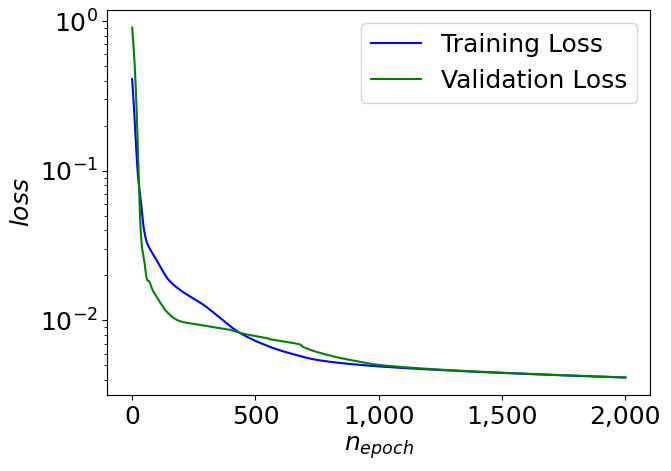

In [81]:
solver.plot_loss_history()

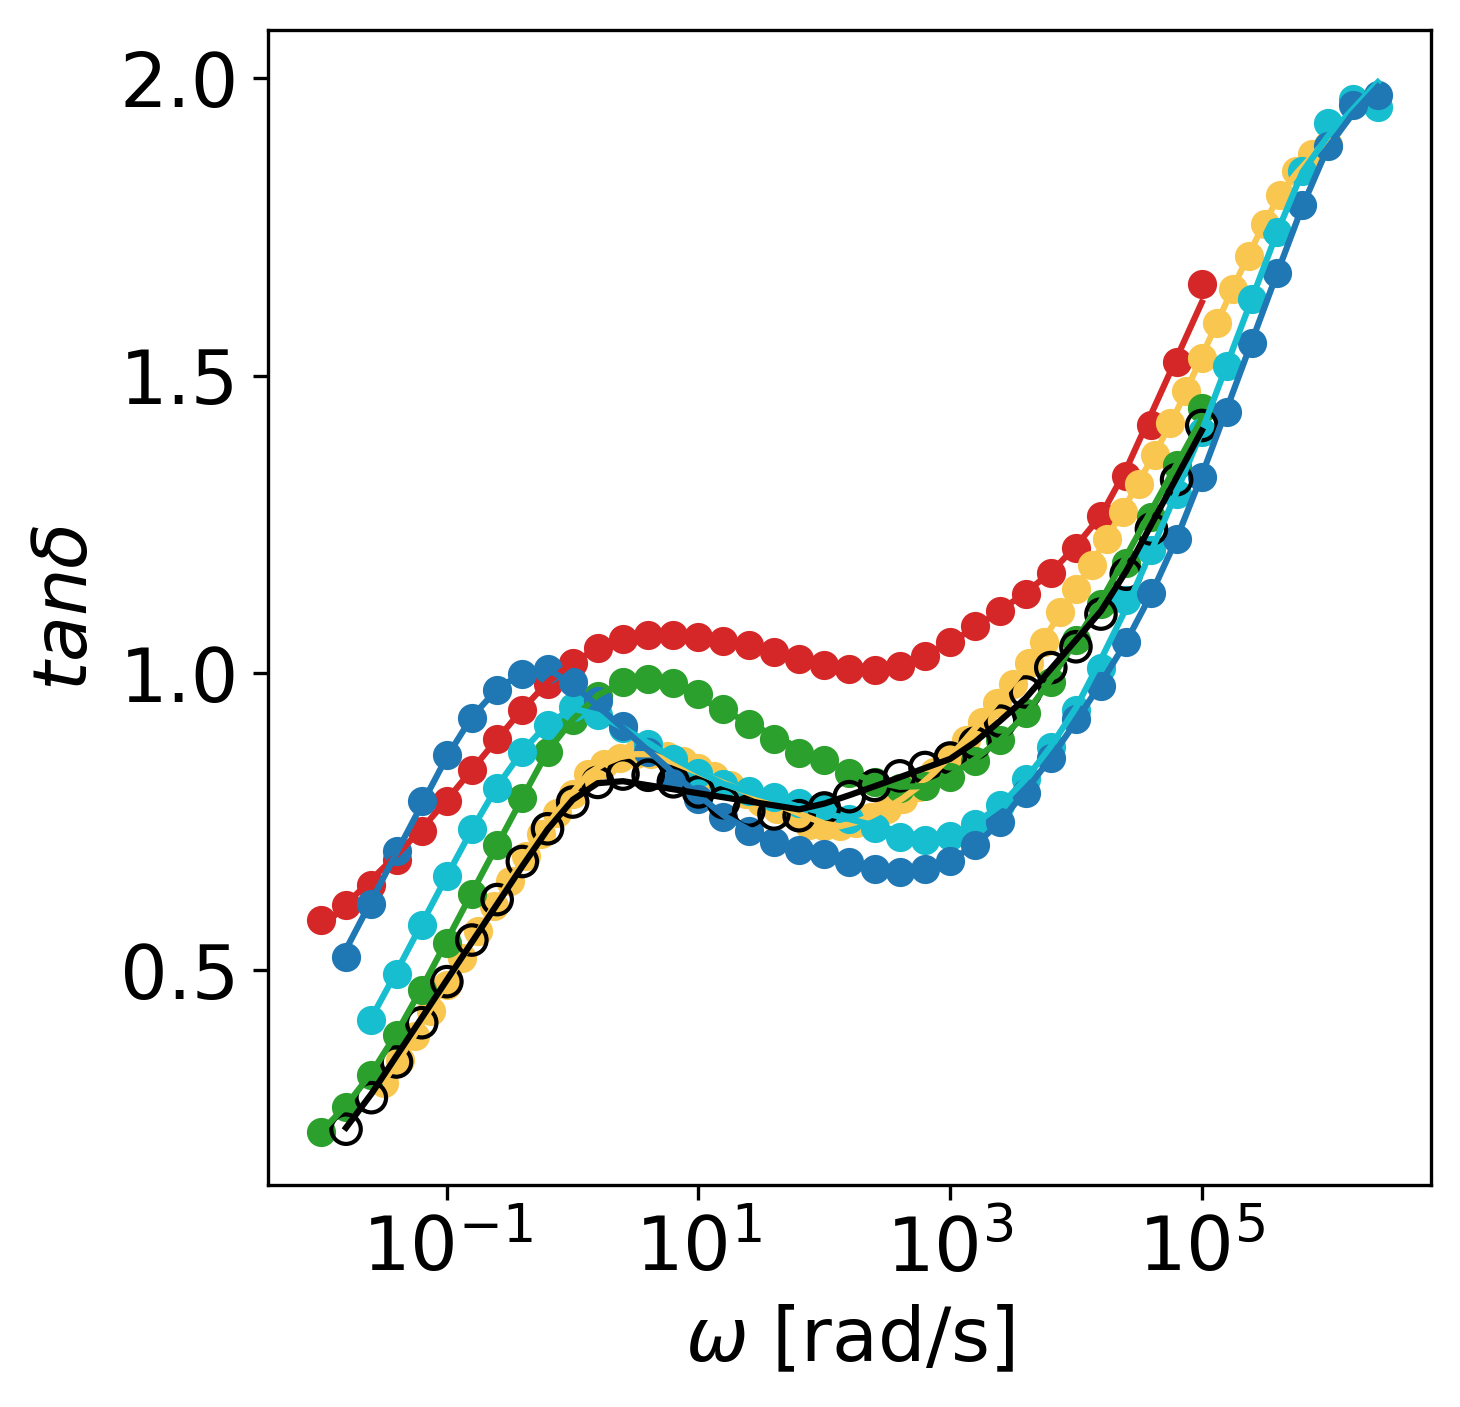

In [82]:
# 设置绘图样式
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

# 将模型设置为评估模式
model_HF_nl.eval()

# 创建图表
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# 对训练集进行预测并绘制
for i, sheet_name in enumerate(df_HF.keys()):
    if sheet_name == 'b2':
        continue  # 跳过验证集
    
    # 提取当前 sheet 的数据
    df = df_HF[sheet_name].dropna()
    y1_train = df['lossF'].to_numpy()
    X_train = df[feature_columns].to_numpy()
    
    # 对频率特征进行对数化处理
    X_train[:, 0] = np.log10(X_train[:, 0])
    
    # 对当前 sheet 的数据进行归一化
    X_train_normalized = x_scaler.transform(X_train)
    y_train_normalized = y_scaler.transform(y1_train.reshape(-1, 1))
    
    # 将数据转换为 PyTorch 张量
    X_data_train = torch.tensor(X_train_normalized, dtype=torch.float32)
    y_data_train = torch.tensor(y_train_normalized, dtype=torch.float32)
    
    # 模型预测
    y_MF_train = model_HF_nl(X_data_train)+model_HF_l(X_data_train)
    y_MF_train_denorm = y_scaler.inverse_transform(y_MF_train.detach().numpy())
    
    # 绘制当前 sheet 的拟合曲线
    ax.plot(10**X_train[:, 0], y_MF_train_denorm, color=colors[i], label=f'Train {sheet_name}')
    ax.scatter(10**X_train[:, 0], y1_train, color=colors[i], label=f'Train {sheet_name}')
# 对验证集进行预测并绘制
y_MF_valid = model_HF_nl(X_data_valid)+model_HF_l(X_data_valid)
y_MF_valid_denorm = y_scaler.inverse_transform(y_MF_valid.detach().numpy())

# 绘制验证集的拟合曲线
ax.plot(10**X_valid[:, 0], y_MF_valid_denorm, color='black', label='Validation Fit')

# 绘制验证集的真实值（空心圆）
y1_valid_denorm = y_scaler.inverse_transform(y_data_valid.numpy())
ax.scatter(10**X_valid[:, 0], y1_valid_denorm, color='black', marker='o', facecolors='none', s=50, label='Validation Data')

# 设置图表属性
ax.set_xscale('log')
ax.set_ylabel('$tan\delta$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
plt.show()